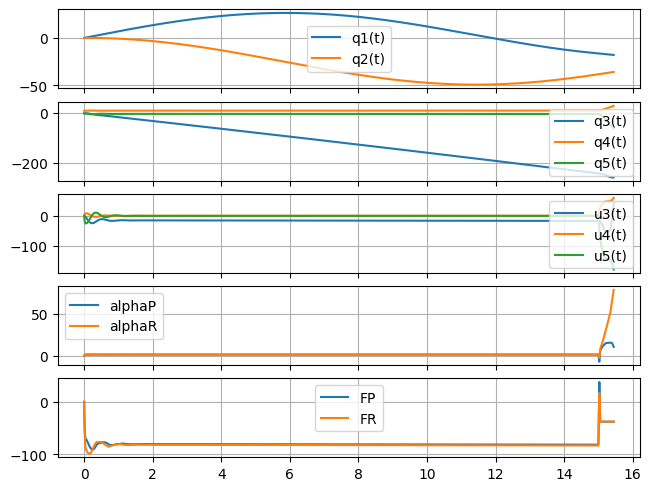

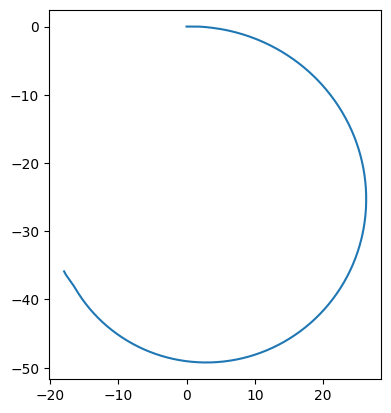

In [1]:
import numpy as np
import sympy as sm
import sympy.physics.mechanics as me
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import inspect

# %%
# Specify the equations of motion
# -------------------------------
#
# The model is constructed using several constant parameters:
#
# - :math:`h`: distance mass center is from the ground contact line
# - :math:`a`: longitudinal distance of the mass center from the rear contact
# - :math:`b`: wheelbase length
# - :math:`g`: acceleration due to gravity
# - :math:`m`: mass of bicycle and rider
# - :math:`I_1`: roll principle moment of inertia
# - :math:`I_2`: pitch principle moment of inertia
# - :math:`I_3`: yaw principle moment of inertia
h, a, b, g = sm.symbols('h a, b, g', real=True)
m, I1, I2, I3 = sm.symbols('m, I1, I2, I3', real=True)
CaP, CaR = sm.symbols('CaP, CaR', real=True)

q1, q2, q3, q4, q5 = me.dynamicsymbols('q1, q2, q3, q4, q5', real=True)
u1, u2, u3, u4, u5 = me.dynamicsymbols('u1, u2, u3, u4, u5', real=True)
t = me.dynamicsymbols._t

q = sm.Matrix([q1, q2, q3, q4])
u = sm.Matrix([u1, u2, u3, u4])
p = sm.Matrix([h, a, b, g, m, I1, I2, I3, ])#CaP, CaR
r = sm.Matrix([q5, u5])

N, A, B, C = sm.symbols('N, A, B, C', cls=me.ReferenceFrame)
O, P, Q, R, S = sm.symbols('O, P, Q, R, S',  cls=me.Point)

A.orient_axis(N, q3, N.z)
B.orient_axis(A, q4, A.x)
C.orient_axis(A, q5, A.z)

P.set_pos(O, q1*N.x + q2*N.y)
Q.set_pos(P, a*A.x)
R.set_pos(P, b*A.x)
S.set_pos(Q, h*B.z)

A.set_ang_vel(N, u3*N.z)
B.set_ang_vel(A, u4*A.x)
C.set_ang_vel(A, u5*A.z)

O.set_vel(N, 0)
P.set_vel(N, u1*N.x + u2*N.y)
Q.v2pt_theory(P, N, A)
R.v2pt_theory(P, N, A)
S.v2pt_theory(Q, N, B)

IB = me.Inertia.from_inertia_scalars(S, B, I1, I2, I3)

bike_body = me.RigidBody('bike', S, B, m, IB)

alphaP = sm.atan(P.vel(N).dot(A.y) / P.vel(N).dot(A.x))
alphaR = sm.atan(R.vel(N).dot(C.y) / R.vel(N).dot(C.x))

gravity = me.Force(S, -m*g*N.z)
rear_tire = me.Force(P, -CaP*alphaP*A.y)
front_tire = me.Force(R, -CaR*alphaR*C.y)

kane = me.KanesMethod(
    N,
    (q1, q2, q3, q4),
    (u1, u2, u3, u4),
    kd_eqs=(u1 - q1.diff(t),
            u2 - q2.diff(t),
            u3 - q3.diff(t),
            u4 - q4.diff(t),)
)

kane.kanes_equations(bodies=(bike_body,),
                     loads=(gravity, front_tire, rear_tire))

eval_eom = sm.lambdify((q, u, r, p, CaP, CaR),
                       (kane.mass_matrix_full, kane.forcing_full))

eval_slip = sm.lambdify((q, u, r, p, CaP, CaR), (alphaP, alphaR))

target_roll_angle = np.deg2rad(10.0)
initial_speed = 7.0  # m/s


# Create empty arrays to store slip angles and tire forces
alphaP_history = []
alphaR_history = []
FyP_history = []
FyR_history = []

time_history = []

def control(t, q, u):
    gain = 3.0
    return np.array([gain*(target_roll_angle - q[3]), -gain*u[3]])


def rhs(t, x, p):
    q = x[0:4]
    u = x[4:8]
    r = control(t, q, u)

     # Update CaP and CaR based on time
    if 15 <= t <= 19.0:
        CaP = 360.0  # for car on ice the value is normalized btwn 0.05 and 0.1 from the book on your PPT slide
        CaR = 360.0  # 
    else:
        CaP = 3600.0  # for a car the value is normalized between 0.8 and 1.0
        CaR = 3600.0  # 

 # Evaluate the equations of motion with the updated parameters
    M, F = eval_eom(q, u, r, p, CaP, CaR)

    # Evaluate slip angles
    alphaP_val, alphaR_val = eval_slip(q, u, r, p, CaP, CaR)

    alphaP_history.append(alphaP_val)
    alphaR_history.append(alphaR_val)

    # Cap slip angles at 6 degrees
    alpha_max = np.deg2rad(6.0)
    alphaP_val = np.clip(alphaP_val, -alpha_max, alpha_max)
    alphaR_val = np.clip(alphaR_val, -alpha_max, alpha_max)

    # Calculate tire forces
    time_history.append(t)
    FyP = -CaP * alphaP_val
    FyR = -CaR * alphaR_val
    FyP_history.append(FyP)
    FyR_history.append(FyR)


    return np.linalg.solve(M, F.squeeze())


x0 = np.array([
    0.0,
    0.0,
    0.0,
    target_roll_angle,  # q4 [rad]
    initial_speed,  # u1 [m/s]
    0.0,
    0.0,
    0.0,
])

p_vals = np.array([
    1.0,  # h [m]
    0.5,  # a [m]
    1.0,  # b [m]
    9.81,  # g [m/s^2]
    87.0,  # m [kg]
    9.2,  # I1 [kg m^2]
    11.0,  # I2 [kg m^2]
    2.8,  # I3 [kg m^2]
    # 3600.0,  # CaP, Fig 7.4 in Gabriele's thesis shows Ca=(100 N / 2 deg)
    # 3600.0,  # CaR
])
def roll_angle_event(t, x, p):
    """
    Event function to stop the solver if roll angle (theta) exceeds 60 or goes below -60 degrees.
    """
    roll_angle = np.rad2deg(x[3])  # x[3] is the roll angle (theta), converted to degrees
    max_angle = 30  # Upper and lower bounds in degrees
    
    # Return the difference between the roll angle and the bounds
    # The event is triggered when this value crosses zero
    return roll_angle**2 - max_angle**2  # Returns 0 when |roll_angle| == max_angle

# Set the event properties
roll_angle_event.terminal = True  # Stop the solver when the event is triggered
roll_angle_event.direction = 0    # Detect event when crossing from either direction (positive or negative)

solution = solve_ivp(rhs, (0.0, 20.0), x0, args=(p_vals,),  events=roll_angle_event)

qs = solution.y[0:4]
us = solution.y[4:8]
rs = control(solution.t, qs, us)
alphaPs, alphaRs = eval_slip(qs, us, rs, p_vals, CaP, CaR)

# fig, axes = plt.subplots(5, 1, sharex=True, layout='constrained')
# axes[0].plot(solution.t, qs[0:2].T)
# axes[0].legend(q[0:2])
# axes[0].grid()
# axes[1].plot(solution.t, np.rad2deg(qs[2:4].T), solution.t, np.rad2deg(rs[0]))
# axes[1].legend([q3, q4, q5])
# axes[1].grid()
# axes[2].plot(solution.t, np.rad2deg(us[2:4].T), solution.t, np.rad2deg(rs[1]))
# axes[2].legend([u3, u4, u5])
# axes[2].grid()
# axes[3].plot(solution.t, np.rad2deg(alphaPs), solution.t, np.rad2deg(alphaRs))
# axes[3].legend(['alphaP', 'alphaR'])
# axes[3].grid()
# axes[4].plot(solution.t, FyP_history,
#              solution.t, FyR_history)
# axes[4].legend(['FP', 'FR'])
# axes[4].grid()

# After running solve_ivp(), add this:

# Convert stored values to numpy arrays
alphaP_arr = np.array(alphaP_history).squeeze()
alphaR_arr = np.array(alphaR_history).squeeze()
FyP_arr = np.array(FyP_history).squeeze()
FyR_arr = np.array(FyR_history).squeeze()

# Create time array for stored values (from the solver's internal steps)
internal_times = np.array(time_history)  # You'll need to store time in rhs()

# Create interpolation functions
from scipy.interpolate import interp1d
interp_alphaP = interp1d(internal_times, alphaP_arr, bounds_error=False, fill_value="extrapolate")
interp_alphaR = interp1d(internal_times, alphaR_arr, bounds_error=False, fill_value="extrapolate")
interp_FyP = interp1d(internal_times, FyP_arr, bounds_error=False, fill_value="extrapolate")
interp_FyR = interp1d(internal_times, FyR_arr, bounds_error=False, fill_value="extrapolate")

# Get values at solution time points
alphaP_plot = interp_alphaP(solution.t)
alphaR_plot = interp_alphaR(solution.t)
FyP_plot = interp_FyP(solution.t)
FyR_plot = interp_FyR(solution.t)

# Now create your plots
fig, axes = plt.subplots(5, 1, sharex=True, layout='constrained')

# Plot positions (unchanged)
axes[0].plot(solution.t, qs[0:2].T)
axes[0].legend(q[0:2])
axes[0].grid()

# Plot angles (unchanged)
axes[1].plot(solution.t, np.rad2deg(qs[2:4].T), solution.t, np.rad2deg(rs[0]))
axes[1].legend([q3, q4, q5])
axes[1].grid()

# Plot velocities (unchanged)
axes[2].plot(solution.t, np.rad2deg(us[2:4].T), solution.t, np.rad2deg(rs[1]))
axes[2].legend([u3, u4, u5])
axes[2].grid()

# Plot slip angles using stored values
axes[3].plot(solution.t, np.rad2deg(alphaP_plot), solution.t, np.rad2deg(alphaR_plot))
axes[3].legend(['alphaP', 'alphaR'])
axes[3].grid()

# Plot tire forces using stored values
axes[4].plot(solution.t, FyP_plot, solution.t, FyR_plot)
axes[4].legend(['FP', 'FR'])
axes[4].grid()


fig, ax = plt.subplots()
ax.plot(qs[0], qs[1])
ax.set_aspect('equal')

plt.show()



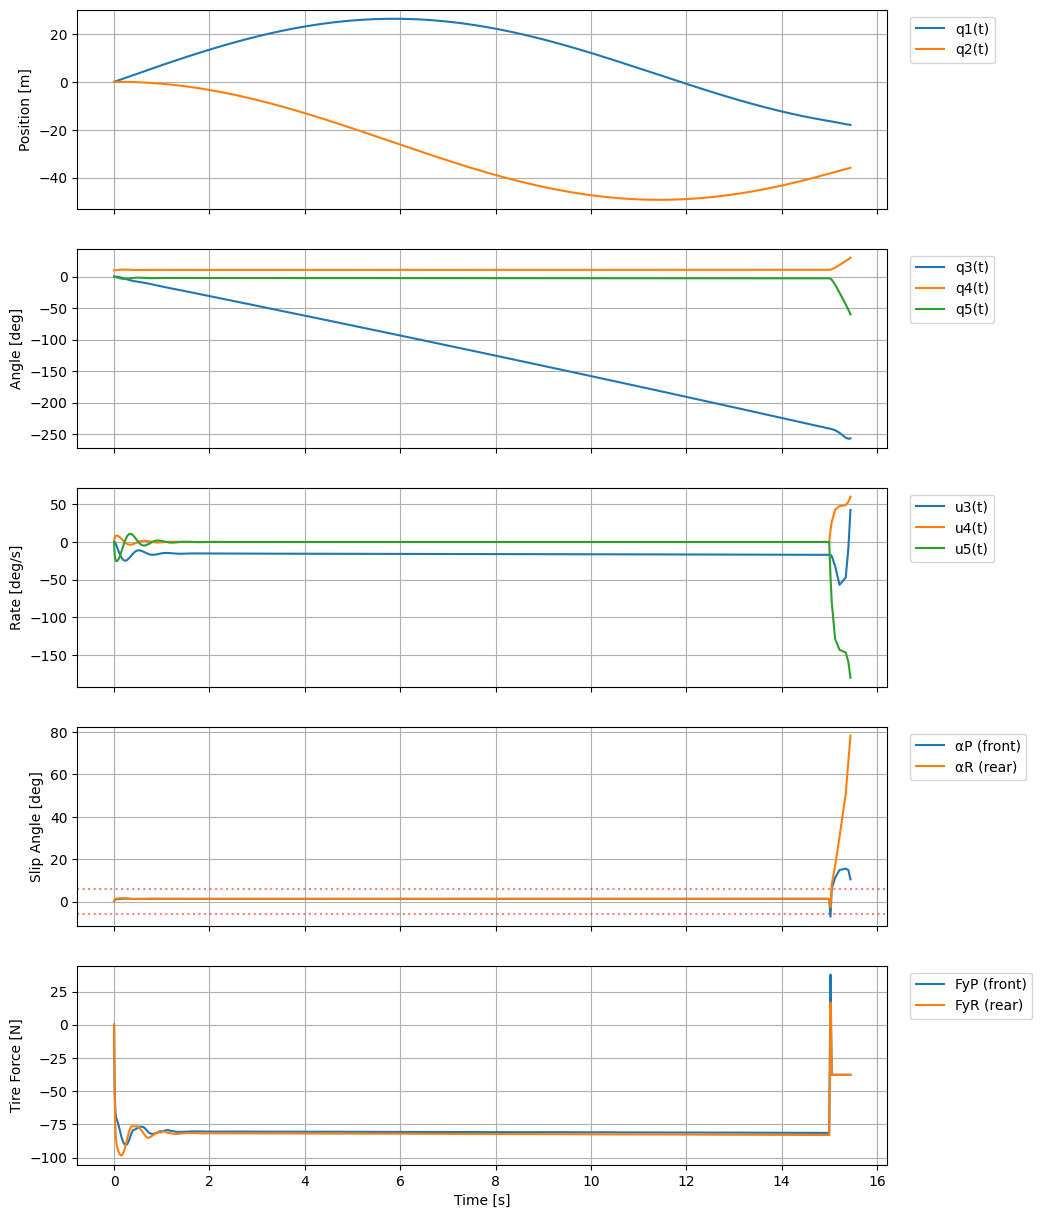

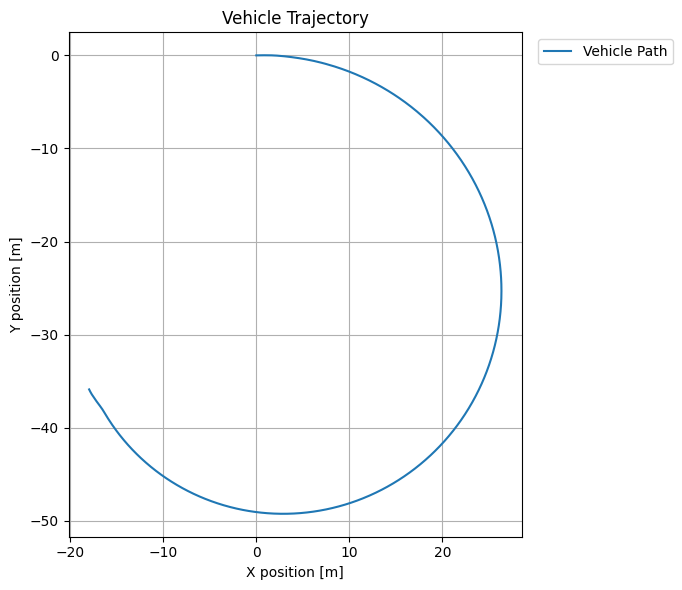

In [2]:
# Create the figure with adjusted right margin for legends
fig, axes = plt.subplots(5, 1, sharex=True, figsize=(12, 15))
plt.subplots_adjust(right=0.8)  # Make room for legends on the right

# Plot 1: Position states
axes[0].plot(solution.t, qs[0:2].T)
axes[0].legend(q[0:2], bbox_to_anchor=(1.02, 1), loc='upper left')
axes[0].grid()
axes[0].set_ylabel('Position [m]')

# Plot 2: Angles
axes[1].plot(solution.t, np.rad2deg(qs[2:4].T), solution.t, np.rad2deg(rs[0]))
axes[1].legend([q3, q4, q5], bbox_to_anchor=(1.02, 1), loc='upper left')
axes[1].grid()
axes[1].set_ylabel('Angle [deg]')

# Plot 3: Rates
axes[2].plot(solution.t, np.rad2deg(us[2:4].T), solution.t, np.rad2deg(rs[1]))
axes[2].legend([u3, u4, u5], bbox_to_anchor=(1.02, 1), loc='upper left')
axes[2].grid()
axes[2].set_ylabel('Rate [deg/s]')

# Plot 4: Slip angles
axes[3].plot(solution.t, np.rad2deg(alphaP_plot), solution.t, np.rad2deg(alphaR_plot))
axes[3].legend(['αP (front)', 'αR (rear)'], bbox_to_anchor=(1.02, 1), loc='upper left')
axes[3].grid()
axes[3].set_ylabel('Slip Angle [deg]')
axes[3].axhline(6, color='r', linestyle=':', alpha=0.5)  # Max slip reference
axes[3].axhline(-6, color='r', linestyle=':', alpha=0.5)

# Plot 5: Tire forces
axes[4].plot(solution.t, FyP_plot, solution.t, FyR_plot)
axes[4].legend(['FyP (front)', 'FyR (rear)'], bbox_to_anchor=(1.02, 1), loc='upper left')
axes[4].grid()
axes[4].set_ylabel('Tire Force [N]')
axes[4].set_xlabel('Time [s]')

# Trajectory plot with legend on side
fig2, ax = plt.subplots(figsize=(8, 6))
ax.plot(qs[0], qs[1], label='Vehicle Path')
ax.set_aspect('equal')
ax.set_xlabel('X position [m]')
ax.set_ylabel('Y position [m]')
ax.set_title('Vehicle Trajectory')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(True)

plt.tight_layout()
plt.show()

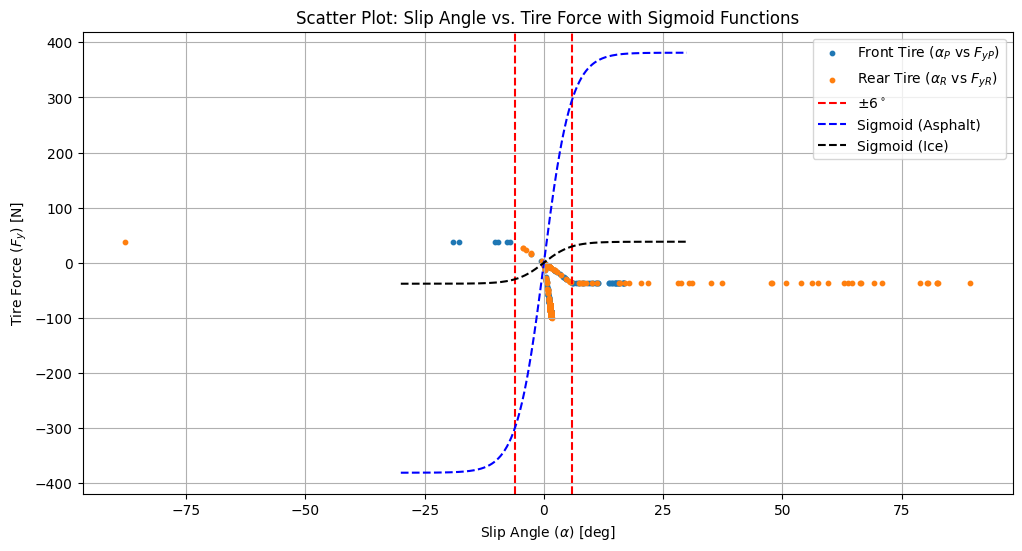

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Scatter plot of alpha_P vs FyP and alpha_R vs FyR
plt.figure(figsize=(12, 6))

# Front tire: alpha_P vs FyP
plt.scatter(np.rad2deg(alphaP_history), FyP_history, label="Front Tire ($\\alpha_P$ vs $F_{yP}$)", s=10)

# Rear tire: alpha_R vs FyR
plt.scatter(np.rad2deg(alphaR_history), FyR_history, label="Rear Tire ($\\alpha_R$ vs $F_{yR}$)", s=10)

# Add vertical lines at ±6° to show the capping
plt.axvline(-6, color='r', linestyle='--', label="$\pm 6^\circ$")
plt.axvline(6, color='r', linestyle='--')

# Define the standard equation (sigmoid function)
def sigmoid(x, a, k, x0, c):
    return a / (1 + np.exp(-k * (x - x0))) + c

Ct_ice = 360
Ct_norm = 3600

# Parameters for the sigmoid function (asphalt)
a_asphalt = 0.21176 * Ct_norm  # Maximum value
k_asphalt = 0.35  # Steepness
x0_asphalt = 0    # Horizontal shift
c_asphalt = -a_asphalt / 2  # Vertical shift

# # Parameters for the sigmoid function (snow)
# a_snow = 0.21176 * Ct_ice  # Maximum value
# k_snow = 0.35  # Steepness
# x0_snow = 0    # Horizontal shift
# c_snow = -a_snow / 2  # Vertical shift

# Parameters for the sigmoid function (ice)
a_ice = 0.21176 * Ct_ice  # Maximum value
k_ice = 0.35  # Steepness
x0_ice = 0    # Horizontal shift
c_ice = -a_ice / 2  # Vertical shift

# Generate a range of slip angles for plotting the sigmoid functions
alpha_degrees = np.linspace(-30, 30, 400)

# Compute the sigmoid function values
sigmoid_values_asphalt = sigmoid(alpha_degrees, a_asphalt, k_asphalt, x0_asphalt, c_asphalt)
# sigmoid_values_snow = sigmoid(alpha_degrees, a_snow, k_snow, x0_snow, c_snow)
sigmoid_values_ice = sigmoid(alpha_degrees, a_ice, k_ice, x0_ice, c_ice)

# Plot the sigmoid functions
plt.plot(alpha_degrees, sigmoid_values_asphalt, label='Sigmoid (Asphalt)', linestyle='--', color='blue')
# plt.plot(alpha_degrees, sigmoid_values_snow, label='Sigmoid (Snow)', linestyle='--', color='orange')
plt.plot(alpha_degrees, sigmoid_values_ice, label='Sigmoid (Ice)', linestyle='--', color='black')

# Labels and title
plt.xlabel("Slip Angle ($\\alpha$) [deg]")
plt.ylabel("Tire Force ($F_y$) [N]")
plt.title("Scatter Plot: Slip Angle vs. Tire Force with Sigmoid Functions")
plt.legend()
plt.grid(True)
plt.show()

### It doesnt have values above 6 for asphault unless I remove the roll event, then it will ####
